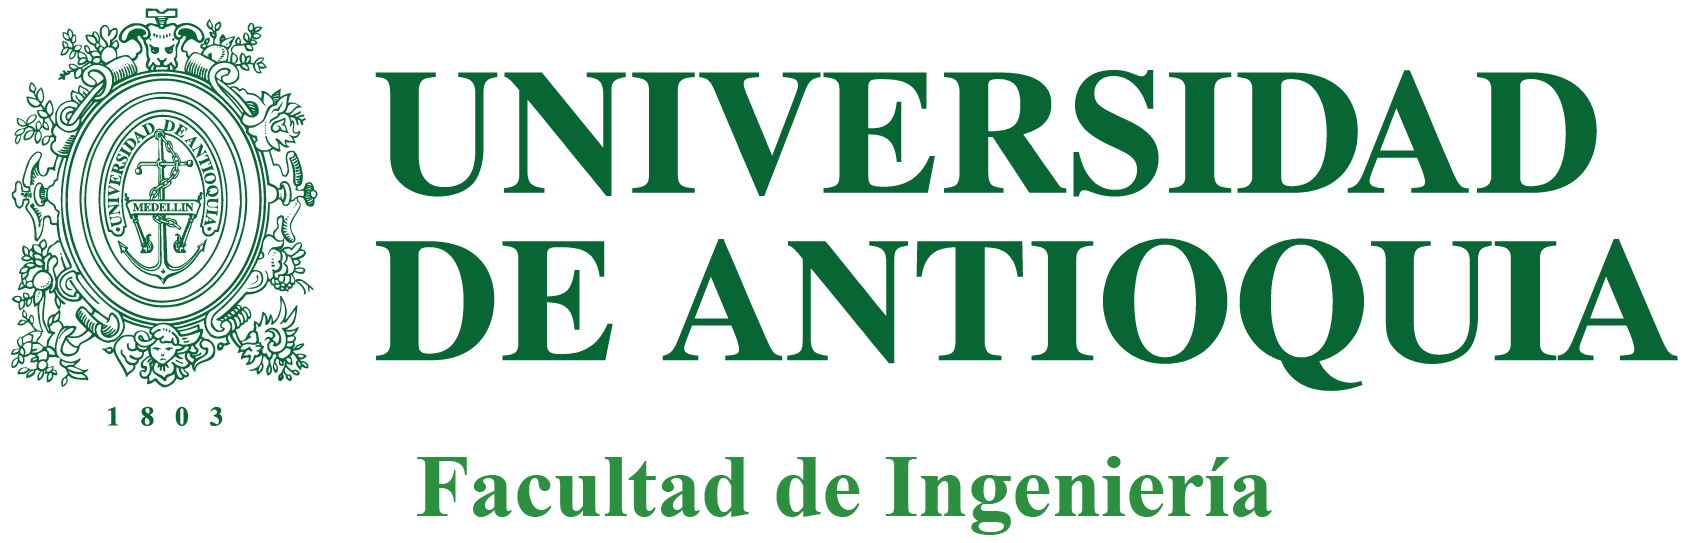
---
- **Asignatura:** Tratamiento de Señales III
- **Autores:**
- Juan Diego Sánchez Ramos
- Juan José Torres Patiño
- **Profesor:** Hernán Felipe García Arias
- **Ingeniería de Telecomunicaciones**
- **UdeA**
- **2023-2**

---

# Final Project Assignment: Modulation Recognition Using Convolutional Neural Networks (CNN) with Database


In [ ]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
%matplotlib inline

In [ ]:
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten, BatchNormalization
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.optimizers import adam

## Datos




In [ ]:
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:05<00:00, 116MB/s]


In [ ]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

## Formato

Los datos que se guardaron contenían una gran matriz de diccionario de Python. Las claves del diccionario eran las combinaciones de tipo de modulación y relaciones señal-ruido (SNR) que fueron simuladas por GNU Radio para producir los datos. Hay 11 esquemas de modulación: 8 digitales y 3 analógicos. Se añadió ruido blanco gaussiano a cada señal proporcional a la potencia de la señal.

Por ejemplo, se simuló una señal modulada BPSK con SNR de -20 dB, -18 dB, -16 dB, hasta 18 dB. Para una SNR de 0, la señal BPSK tendría la misma potencia total que el ruido gaussiano. Para SNR inferiores a 0, la señal BPSK se vería inundada por el ruido. En otras palabras, sería imposible para un humano identificar la modulación de esas SNR.

$$ \text{SNR in decibels} = 10 \times \log \left ( \frac{\text{signal power}}{\text{noise power}} \right ) $$

In [ ]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [ ]:
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


### (RF) Señales de radiofrecuencia

Una vez que hayamos especificado la clave del diccionario (por ejemplo, ['QAM64', 4] para modulación QAM64 a 4 dB SNR), nos quedará la siguiente matriz.

In [ ]:
np.shape(Xd['BPSK', -18])

(1000, 2, 128)

+ La segunda dimensión representa los dos componentes ([I & Q](https://youtu.be/h_7d-m1ehoY)) de la señal de RF.
+ La tercera dimensión representa las 128 muestras en el tiempo (1 MHz, por lo que 1 $\mu$s por índice)
+ La primera dimensión representa las 1000 ventanas muestreadas (cada ventana tiene las 128 muestras I y Q)


$$\text{Modulated Carrier RF} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

In [ ]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

## Tracemos algunos de los datos sin procesar.

Así que elegiremos un 8PSK (con SNR @ 18 dB), un PAM4 (con SNR @ 6 dB), un BPSK (con SNR @ 0 dB) y un QAM64 (con SNR @ -12 dB).

Observe cómo la señal queda enterrada en el ruido a medida que disminuye la SNR.

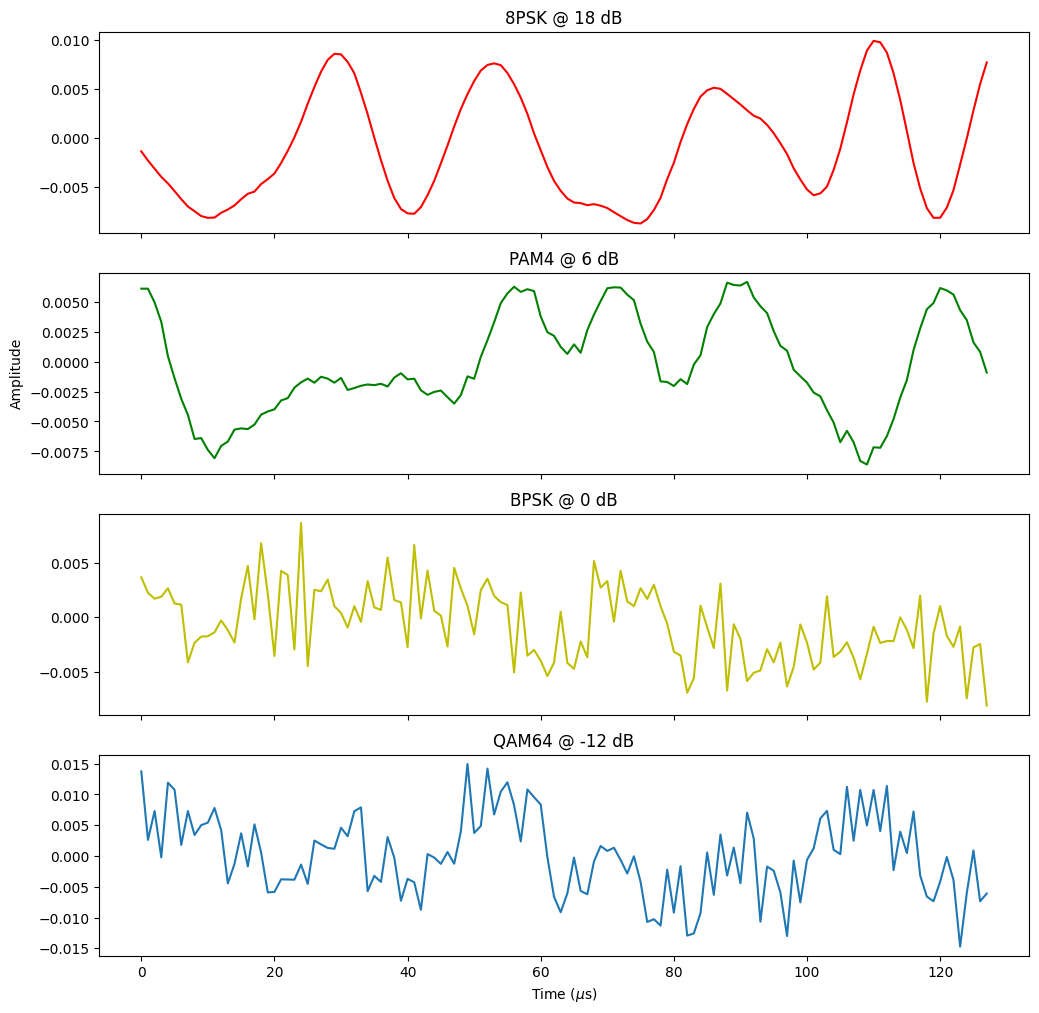

In [ ]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(12, 12))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

## Ahora necesitamos agregar toda la modulación, SNR, muestras, canales y puntos de tiempo en una gran matriz para pasar a nuestra red neuronal.

Entonces habrá 220.000 muestras. Cada muestra es de 2 x 128. Los 2 son los canales I y Q. Las 128 son las 128 muestras de tiempo de la forma de onda (muestreadas a 1 MHz).

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
np.shape(X)

(220000, 2, 128)

## Agregar noise class al conjunto de datos

Entonces, agreguemos 2 canales de ruido gaussiano aleatorio para ver si podemos darle a la red la opción de elegir si no puede decidir entre las modulaciones verdaderas. Esta es básicamente una clasificación de "No sé".

In [ ]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

### Ahora dividamos aleatoriamente el conjunto de datos en un grupo de entrenamiento y un grupo de prueba.

El grupo de entrenamiento se utilizará para calcular los pesos de la red neuronal. El grupo de prueba se utilizará para evaluar (validar) qué tan bien se generalizan esos pesos a nuevos datos (es decir, qué tan bien debería funcionar nuestra red neuronal en la naturaleza).

Nuestro primer paso es [One Hot Encode](https://en.wikipedia.org/wiki/One-hot). Suena mal, pero es un procedimiento realmente sencillo. Básicamente, la computadora no entiende letras; sólo puede utilizar números. Por lo tanto, no tiene idea de a qué se refieren '8PSK' o 'WBFM' y no tiene forma de entrenar un modelo para que se ajuste a esas etiquetas. Ahora podríamos simplemente asignar un número a cada modulación (por ejemplo, 1 = '8PSK', 2 = 'AM-DSB', 3 = 'PAM4', etc.). Sin embargo, la codificación one-hot nos facilita calcular qué tan cerca está la salida de nuestra red neuronal (es decir, la predicción) del valor verdadero (esperado).

Para la codificación one-hot simplemente declaramos un vector que es tan grande como el conjunto de modulaciones únicas. Entonces, si tenemos 11 modulaciones, declaramos un vector de tamaño 1 x 11. La matriz es 0 en todas partes excepto en la modulación que se representa. Por ejemplo,

+ [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] códigos '8PSK'
+ [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] códigos 'AM-DSB'
+ [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] códigos 'WBFM'
  
Entonces, el elemento más a la izquierda codifica '8PSK' y el más a la derecha codifica 'WBFM'. El posicionamiento es arbitrario. Simplemente tiene que aplicarse de forma coherente al conjunto de datos.

Una vez que hayamos codificado One Hot, podremos comparar qué tan cerca llega la salida de nuestra red neuronal (es decir, la predicción) a la modulación verdadera. Esta medida de "cercanía" se calcula normalmente mediante entropía cruzada (Shannon). Hay un excelente [video aquí] (https://www.youtube.com/watch?v=tRsSi_sqXjI).

$$ \text{entropía cruzada} = - \sum_i{L_i \log{S_i}}$$

dónde
+ $i$ pasa de 1 al número de modulaciones
+ $L_i$ es la etiqueta única para esa muestra en esa modulación
+ $S_i$ es la predicción de la red neuronal para esa muestra en esa modulación

Por ejemplo, si nuestra red neuronal predice 3 clases con las siguientes probabilidades:

$$\begin{bmatrix}0.2\\0.7\\0.1 \end{bmatrix}$$

y la muestra real tiene la codificación one-hot de:

$$\begin{bmatrix}0\\1\\0\end{bmatrix}$$

Entonces nuestra entropía cruzada es:
$$ - [ 0 \times \log(0.2) + 1 \times \log(0.7) + 0 \times \log(0.1) ] = \log(0.7) = 0.155$$

Si la predicción es perfecta, entonces la entropía cruzada es $1 \times \log(1) = 0$

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lbl = np.array(lbl) # Convert from list to numpy array (for speed)


y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


In [ ]:
y_encoded

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Dividir en un conjunto de entrenamiento y prueba

Es crucial que dividamos los datos en al menos 2 conjuntos. Se utilizará un conjunto (llamado conjunto de entrenamiento) para entrenar la red neuronal. Es decir, los pesos de la red neuronal se ajustarán para realizar la mejor predicción posible de los datos de entrenamiento. Sin embargo, si nos detuviéramos ahí, entonces tendríamos un modelo que fuera bueno para predecir cosas cuyas respuestas ya conocía. Queremos asegurarnos de que el modelo pueda predecir cosas que nunca antes había visto. Por lo tanto, guardamos algunos datos (generalmente entre 1/4 y 1/3) para probar si la red neuronal entrenada puede ser tan precisa en datos que nunca ha visto.

La mayoría de los kits de herramientas de aprendizaje automático decentes contienen un método para dividir aleatoriamente sus datos en estos dos conjuntos. Normalmente usamos el de sklearn (train_test_split). Sin embargo, queremos realizar un seguimiento de los índices para poder obtener también las SNR al final. Entonces usaremos una matriz aleatoria para dividir los dos grupos.

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [ ]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


In [ ]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods
print(classes)

(168000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


# Construir el modelo NN

Su tarea aquí es codificar 2 arquitecturas CNN para evaluar el reconocimiento de modulación utilizando enfoques de aprendizaje profundo.

In [ ]:
dr = 0.5
model = models.Sequential()
model.add(Reshape((2, 128, 1), input_shape=(2,128)))
model.add(Conv2D(16, (1, 8), strides=(1, 2), padding='valid', activation='relu', name='conv1'))
model.add(Conv2D(32, (1, 16), strides=(2, 1), padding='valid', activation='relu', name='conv2'))
model.add(Conv2D(64, (1, 32), strides=(4, 4), padding='valid', activation='relu', name='conv3'))
model.add(Flatten())
model.add(Dense(512, activation='relu', name='dense1'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', name='dense2'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax', name='dense3'))
model.add(Activation('softmax', name='softmax'))
model.add(Reshape((12,), name='reshape2'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 2, 61, 16)         144       
                                                                 
 conv2 (Conv2D)              (None, 1, 46, 32)         8224      
                                                                 
 conv3 (Conv2D)              (None, 1, 4, 64)          65600     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense1 (Dense)              (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0

In [ ]:
model1 = models.Sequential()
model1.add(Reshape((2, 128, 1), input_shape=(2, 128)))

model1.add(Conv2D(32, kernel_size=(2, 8), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(1, 2)))

model1.add(Conv2D(64, kernel_size=(1, 8), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(1, 2)))

model1.add(Conv2D(128, kernel_size=(1, 4), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(1, 2)))

model1.add(Dropout(0.6))
model1.add(Flatten())

model1.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(Dropout(0.6))
model1.add(Dense(12, activation='softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 121, 32)        544       
                                                                 
 batch_normalization (Batch  (None, 1, 121, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 60, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 53, 64)         16448     
                                                                 
 batch_normalization_1 (Bat  (None, 1, 53, 64)        

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model1.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Entrenar el modelo 1

Para el entrenamiento del modelo, utilice `ModelCheckpoint` y `EarlyStopping` para monitorear el entrenamiento y evitar el sobreajuste.

In [ ]:
# Set up some params
nb_epoch = 180     # number of epochs to train on
batch_size = 1024  # training batch size

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset


filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/180

Epoch 1: val_loss improved from inf to 2.39605, saving model to ./PESOS_TSIII.wts.h5
165/165 - 11s - loss: 2.4307 - accuracy: 0.1461 - val_loss: 2.3960 - val_accuracy: 0.2071 - 11s/epoch - 69ms/step
Epoch 2/180


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 2.39605 to 2.37099, saving model to ./PESOS_TSIII.wts.h5
165/165 - 1s - loss: 2.3742 - accuracy: 0.2254 - val_loss: 2.3710 - val_accuracy: 0.2297 - 1s/epoch - 9ms/step
Epoch 3/180

Epoch 3: val_loss did not improve from 2.37099
165/165 - 1s - loss: 2.3730 - accuracy: 0.2265 - val_loss: 2.3753 - val_accuracy: 0.2272 - 1s/epoch - 8ms/step
Epoch 4/180

Epoch 4: val_loss improved from 2.37099 to 2.37038, saving model to ./PESOS_TSIII.wts.h5
165/165 - 1s - loss: 2.3726 - accuracy: 0.2269 - val_loss: 2.3704 - val_accuracy: 0.2302 - 1s/epoch - 8ms/step
Epoch 5/180

Epoch 5: val_loss improved from 2.37038 to 2.36935, saving model to ./PESOS_TSIII.wts.h5
165/165 - 1s - loss: 2.3712 - accuracy: 0.2281 - val_loss: 2.3694 - val_accuracy: 0.2317 - 1s/epoch - 9ms/step
Epoch 6/180

Epoch 6: val_loss improved from 2.36935 to 2.36779, saving model to ./PESOS_TSIII.wts.h5
165/165 - 1s - loss: 2.3714 - accuracy: 0.2283 - val_loss: 2.3678 - val_accuracy: 0.2328 - 1s/epoch 

# Evaluar y trazar el rendimiento del modelo 1

In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(X_test, batch_size=batch_size)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_predict, axis=1),target_names=classes))


71/71 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

        8PSK       0.36      0.36      0.36      5957
      AM-DSB       0.54      0.56      0.55      5852
      AM-SSB       0.24      0.93      0.38      5932
        BPSK       0.77      0.40      0.53      6051
       CPFSK       0.73      0.55      0.63      5963
        GFSK       0.67      0.60      0.63      6022
        PAM4       1.00      1.00      1.00      6125
       QAM16       0.61      0.45      0.52      5991
       QAM64       0.28      0.09      0.13      5906
        QPSK       0.44      0.47      0.46      6029
        WBFM       0.46      0.27      0.34      6072
       Noise       0.70      0.17      0.27      6100

    accuracy                           0.49     72000
   macro avg       0.57      0.49      0.48     72000
weighted avg       0.57      0.49      0.48     72000



## Curvas de pérdida modelo 1

Las curvas de pérdidas nos muestran qué tan bien fue el entrenamiento. También nos permiten detectar el sobreentrenamiento del modelo. Si el modelo está sobreentrenado, es posible que no se generalice bien. A menudo, en un modelo sobreentrenado, la pérdida de entrenamiento (error) disminuirá continuamente mientras que la validación (error de prueba) disminuirá y luego comenzará a aumentar nuevamente con sucesivas épocas de entrenamiento.

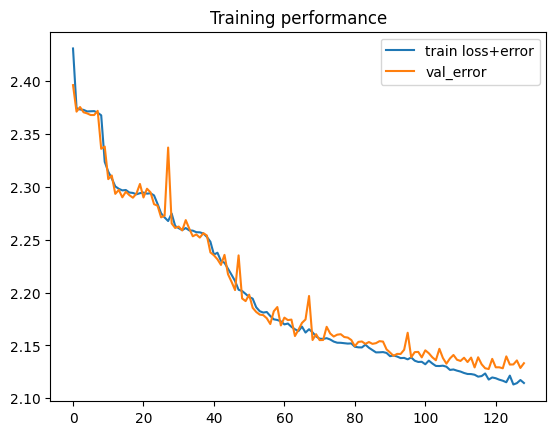

In [ ]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

# Confusion Matrix modelo 1

Una matriz de confusión es una excelente manera de ver dónde tuvo problemas el modelo (red neuronal). Traza el número de veces que el modelo predijo una modulación versus la modulación real (predicha versus verdadera).

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

71/71 [==============================] - 0s 3ms/step


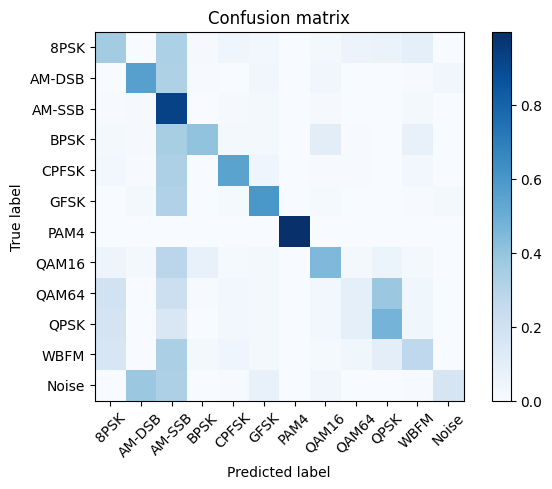

In [ ]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Evalúe el modelo en términos de $SNR$ y su precisión para cada modulación (a continuación se muestra un código de muestra para evaluar sus modelos)

112/112 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -20: 0.16736518580609108
113/113 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -18: 0.17391304347826086
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -16: 0.1721781907625034
114/114 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -14: 0.17466887417218543
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -12: 0.19331872946330778
116/116 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -10: 0.22110689093868693
111/111 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -8: 0.2748091603053435
112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -6: 0.38567030506577105
112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -4: 0.4772536980184203
114/114 [==============================] - 0s 2ms/step
Overal

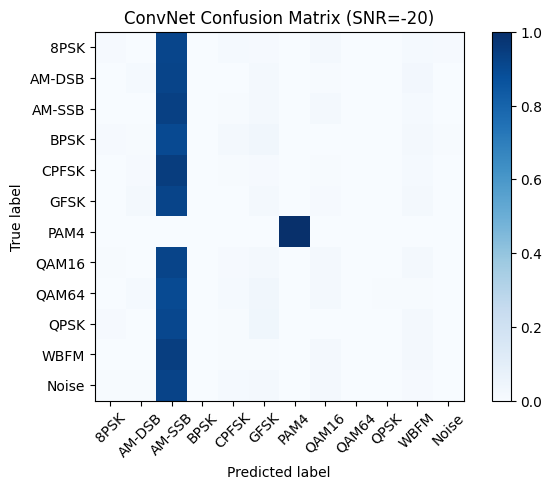

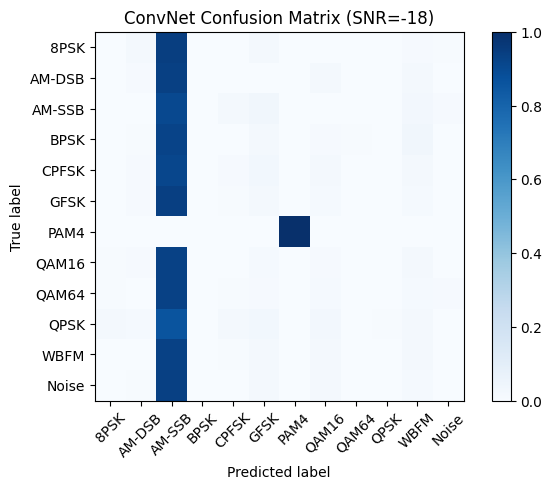

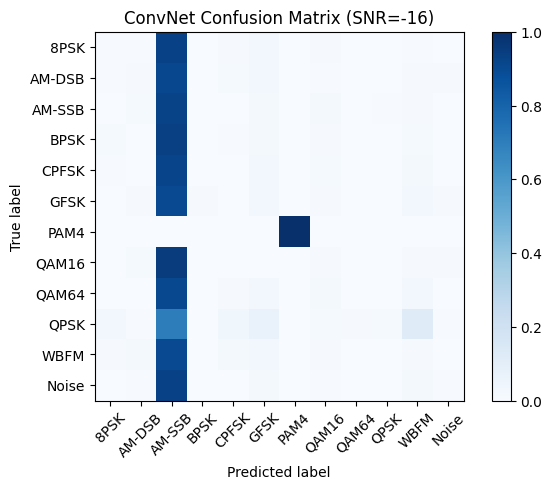

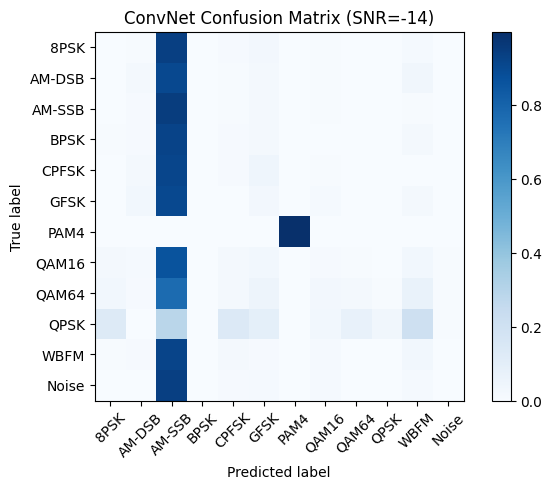

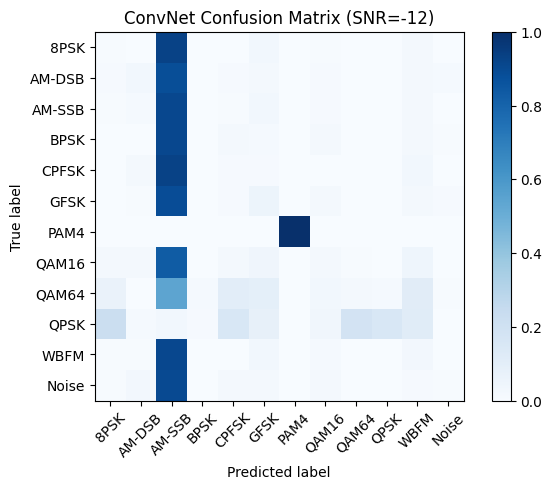

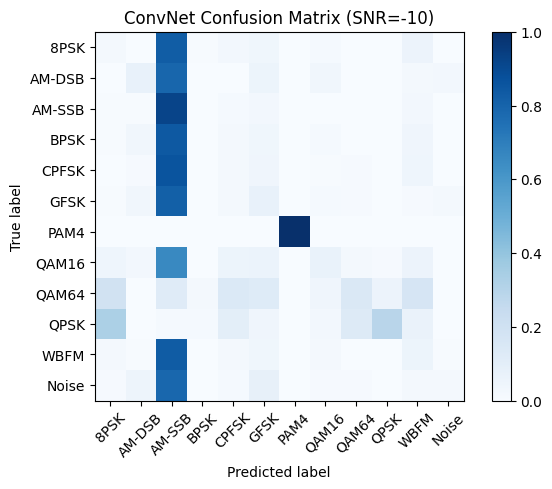

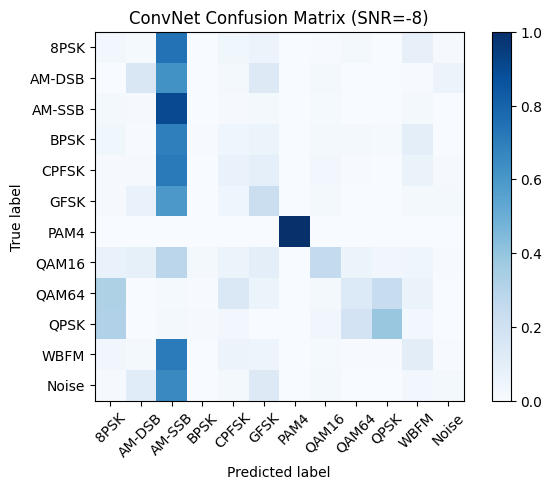

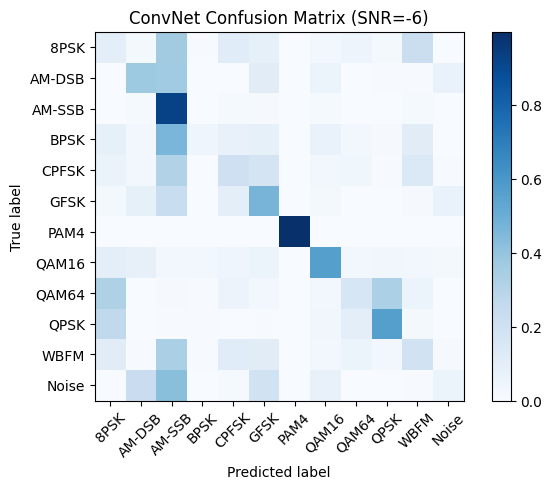

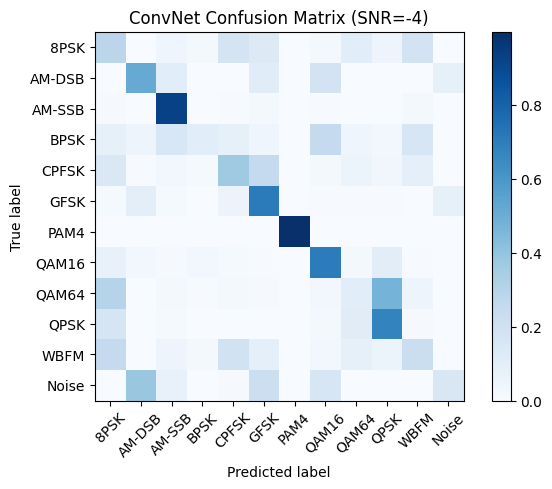

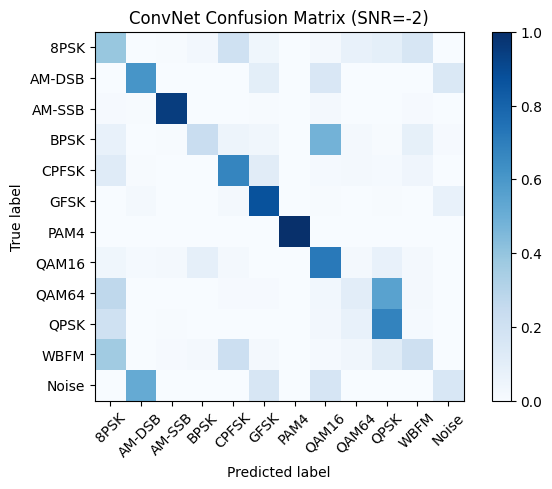

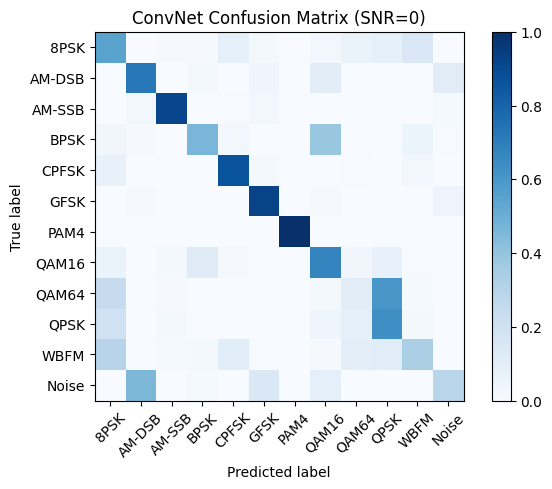

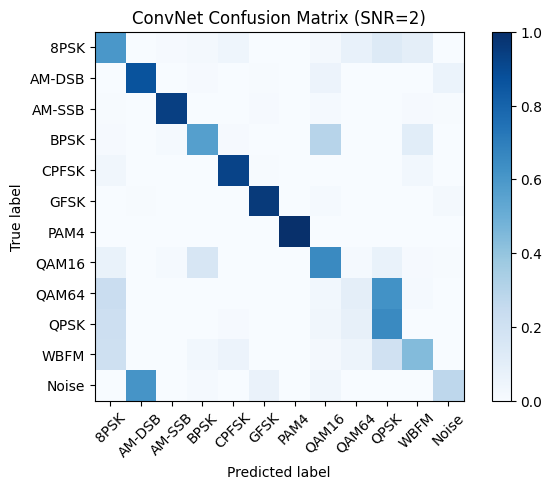

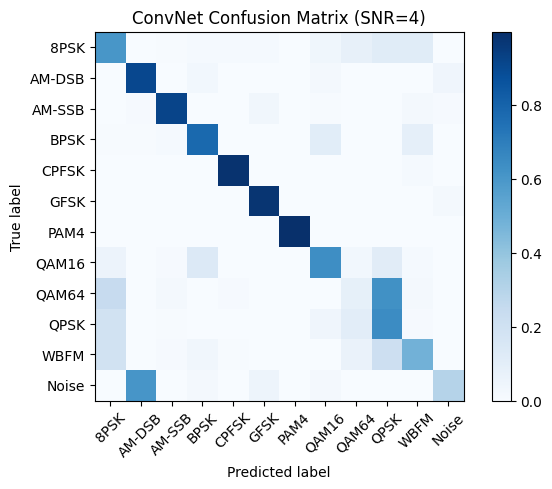

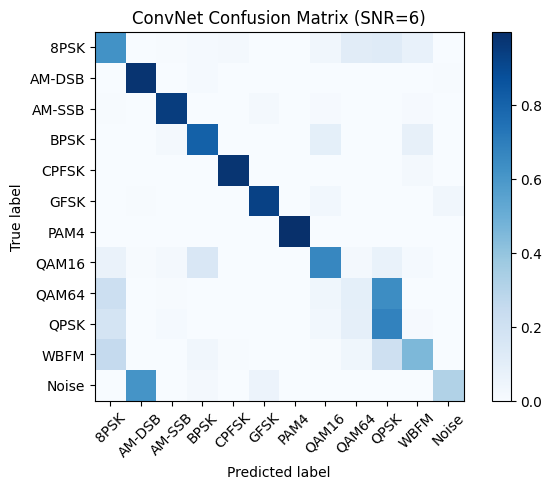

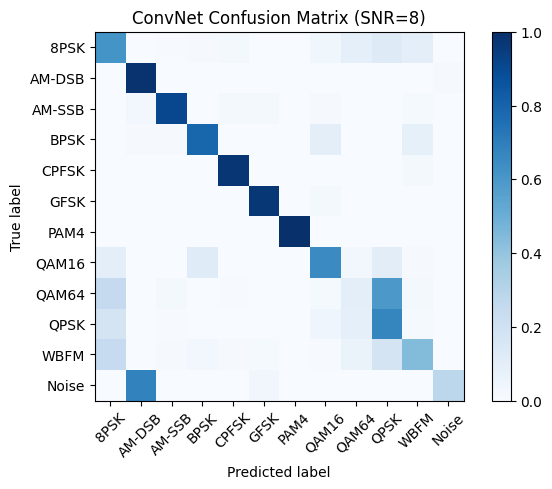

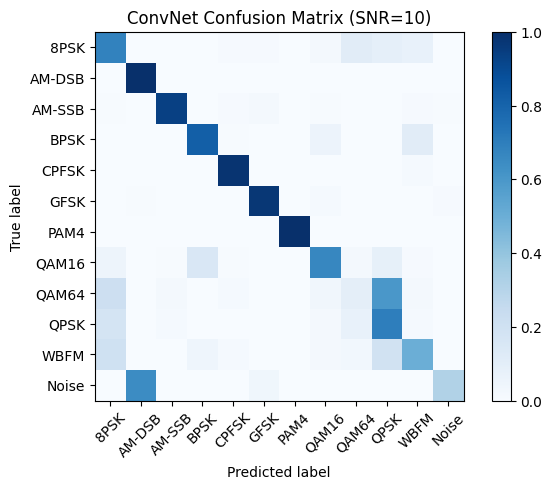

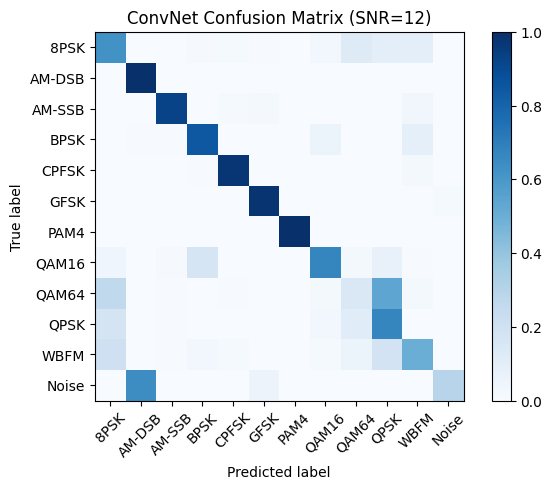

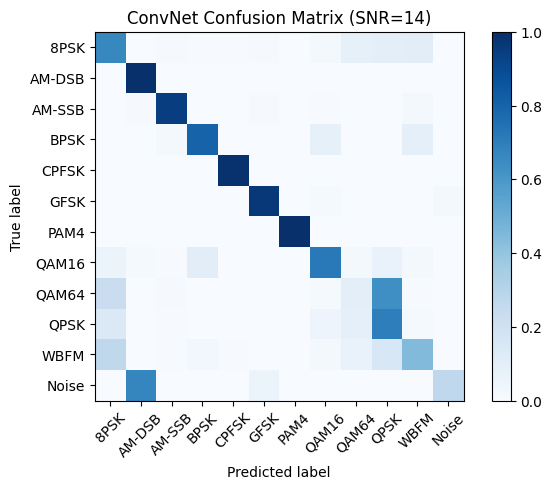

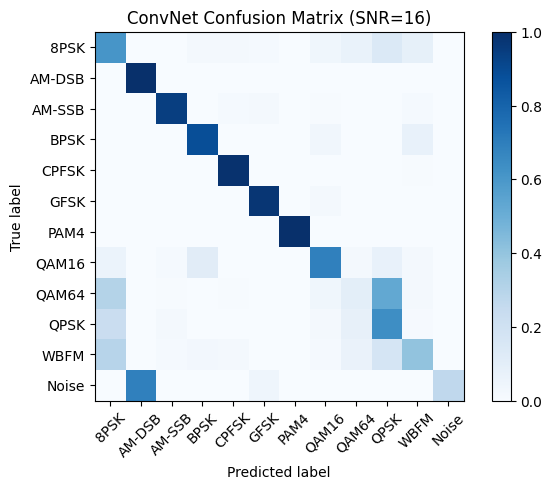

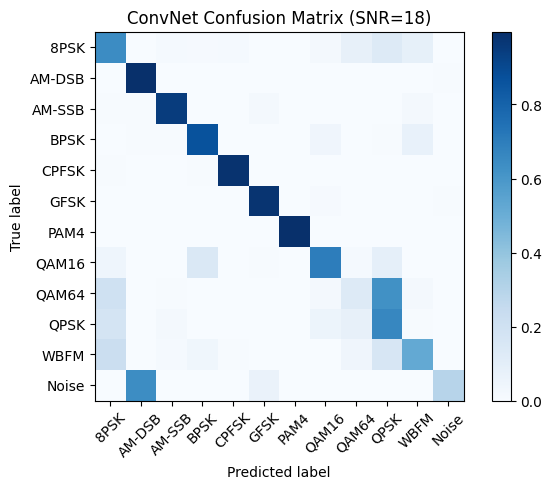

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)

    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)


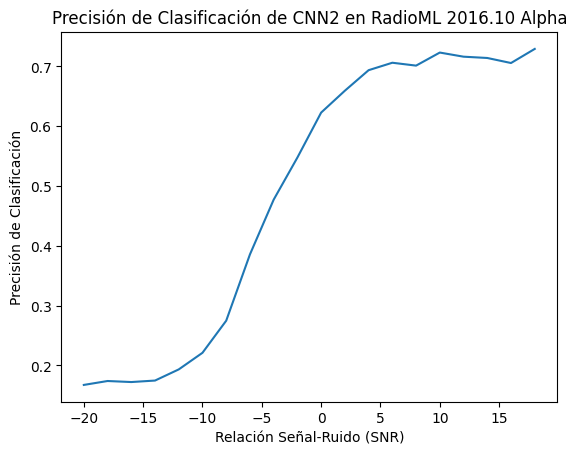

In [ ]:
# Plot accuracy curve
# Convertir el resultado de map en una lista
accuracy_values = [acc[x] for x in snrs]

# Graficar
plt.plot(snrs, accuracy_values)
plt.xlabel("Relación Señal-Ruido (SNR)")
plt.ylabel("Precisión de Clasificación")
plt.title("Precisión de Clasificación de CNN2 en RadioML 2016.10 Alpha")
plt.show()


# Entrenar el modelo 2

Para el entrenamiento del modelo, utilice `ModelCheckpoint` y `EarlyStopping` para monitorear el entrenamiento y evitar el sobreajuste.

In [ ]:
import os

if os.path.exists(modelWeightsFile):
    # Si existe, borrar el archivo
    os.remove(modelWeightsFile)
    print(f"Archivo {modelWeightsFile} borrado.")

Archivo ./PESOS_TSIII.wts.h5 borrado.


In [ ]:
# Set up some params
nb_epoch = 100    # number of epochs to train on
batch_size = 1024  # training batch size

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset

filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model1.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model1.load_weights(modelWeightsFile)

Epoch 1/100

Epoch 1: val_loss improved from inf to 4.13588, saving model to ./PESOS_TSIII.wts.h5
165/165 - 7s - loss: 3.9966 - accuracy: 0.3377 - val_loss: 4.1359 - val_accuracy: 0.0836 - 7s/epoch - 42ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 4.13588
165/165 - 3s - loss: 1.5968 - accuracy: 0.4805 - val_loss: 4.7268 - val_accuracy: 0.0836 - 3s/epoch - 20ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 4.13588
165/165 - 3s - loss: 1.3956 - accuracy: 0.5152 - val_loss: 4.1428 - val_accuracy: 0.1144 - 3s/epoch - 20ms/step
Epoch 4/100

Epoch 4: val_loss improved from 4.13588 to 2.45479, saving model to ./PESOS_TSIII.wts.h5
165/165 - 3s - loss: 1.3452 - accuracy: 0.5290 - val_loss: 2.4548 - val_accuracy: 0.2937 - 3s/epoch - 20ms/step
Epoch 5/100

Epoch 5: val_loss improved from 2.45479 to 1.38500, saving model to ./PESOS_TSIII.wts.h5
165/165 - 3s - loss: 1.3155 - accuracy: 0.5359 - val_loss: 1.3850 - val_accuracy: 0.5074 - 3s/epoch - 20ms/step
Epoch 6/100

Epoch 6: val_loss improved from 1.38500 to 1.36120, saving model to ./PESOS_TSIII.wts.h5
165/165 - 3s - loss: 1.3030 - accuracy: 0.5401 - val_loss: 1.3612 - val_accuracy: 0.5178 - 3s/epoch - 21ms/step
Epoch 7/100

Epoch 7: val_

# Evaluar y trazar el rendimiento del modelo 2

In [ ]:
from sklearn.metrics import classification_report
y_predict = model1.predict(X_test, batch_size=batch_size)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(y_predict, axis=1),target_names=classes))


71/71 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

        8PSK       0.84      0.46      0.60      5957
      AM-DSB       0.50      0.63      0.56      5852
      AM-SSB       0.25      0.95      0.40      5932
        BPSK       0.82      0.60      0.69      6051
       CPFSK       0.81      0.62      0.70      5963
        GFSK       0.85      0.62      0.72      6022
        PAM4       1.00      1.00      1.00      6125
       QAM16       0.91      0.67      0.77      5991
       QAM64       0.40      0.04      0.07      5906
        QPSK       0.53      0.71      0.61      6029
        WBFM       0.73      0.54      0.62      6072
       Noise       0.69      0.23      0.34      6100

    accuracy                           0.59     72000
   macro avg       0.69      0.59      0.59     72000
weighted avg       0.70      0.59      0.59     72000



## Curvas de pérdida modelo 2

Las curvas de pérdidas nos muestran qué tan bien fue el entrenamiento. También nos permiten detectar el sobreentrenamiento del modelo. Si el modelo está sobreentrenado, es posible que no se generalice bien. A menudo, en un modelo sobreentrenado, la pérdida de entrenamiento (error) disminuirá continuamente mientras que la validación (error de prueba) disminuirá y luego comenzará a aumentar nuevamente con sucesivas épocas de entrenamiento.

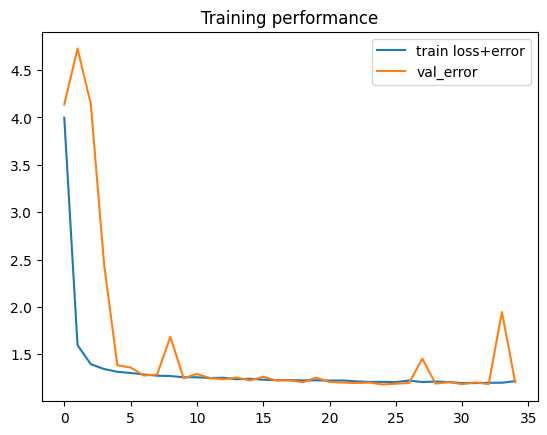

In [ ]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

# Confusion Matrix modelo 2

Una matriz de confusión es una excelente manera de ver dónde tuvo problemas el modelo (red neuronal). Traza el número de veces que el modelo predijo una modulación versus la modulación real (predicha versus verdadera).

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

71/71 [==============================] - 0s 5ms/step


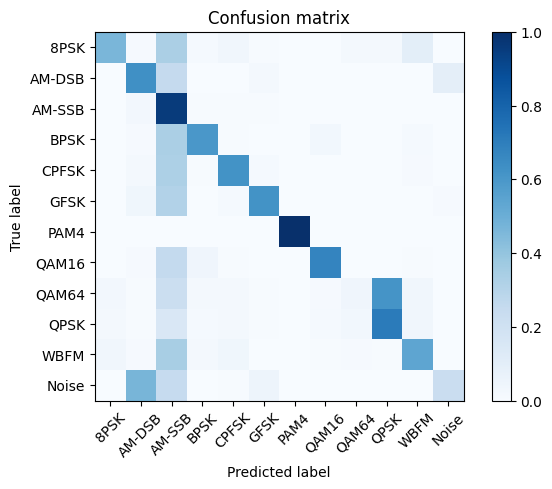

In [ ]:
# Plot confusion matrix
test_Y_hat = model1.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Evalúe el modelo en términos de $SNR$ y su precisión para cada modulación (a continuación se muestra un código de muestra para evaluar sus modelos)

112/112 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -20: 0.16568873987147248
113/113 [==============================] - 0s 2ms/step
Overall Accuracy for SNR -18: 0.17779008584879535
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -16: 0.1727247881934955
114/114 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -14: 0.18129139072847683
115/115 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -12: 0.21248630887185105
116/116 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -10: 0.27916440586001084
111/111 [==============================] - 0s 3ms/step
Overall Accuracy for SNR -8: 0.41164828951088495
112/112 [==============================] - 0s 4ms/step
Overall Accuracy for SNR -6: 0.5365239294710328
112/112 [==============================] - 0s 4ms/step
Overall Accuracy for SNR -4: 0.6497348590566564
114/114 [==============================] - 0s 4ms/step
Overal

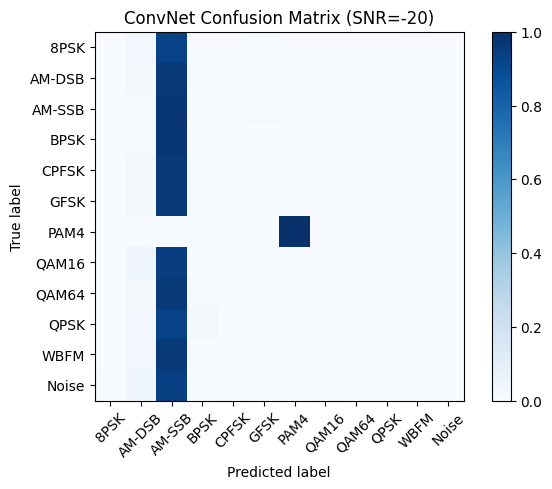

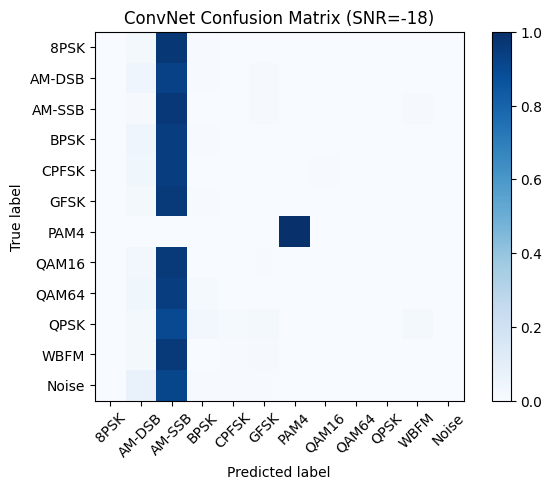

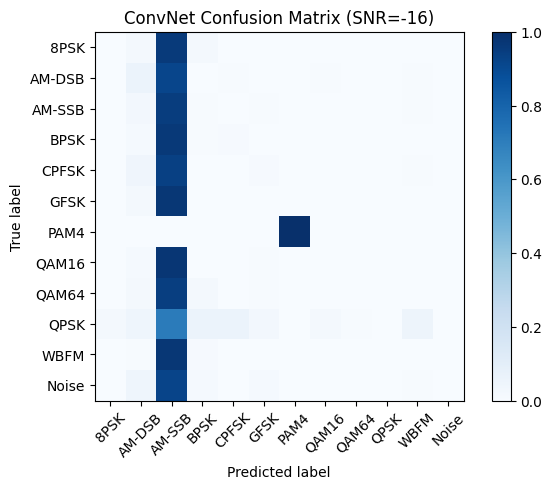

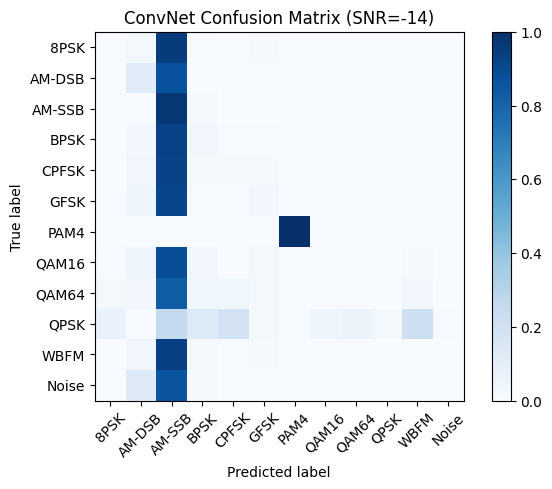

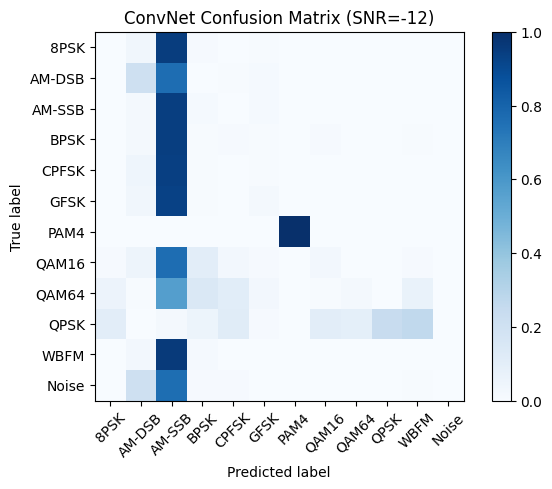

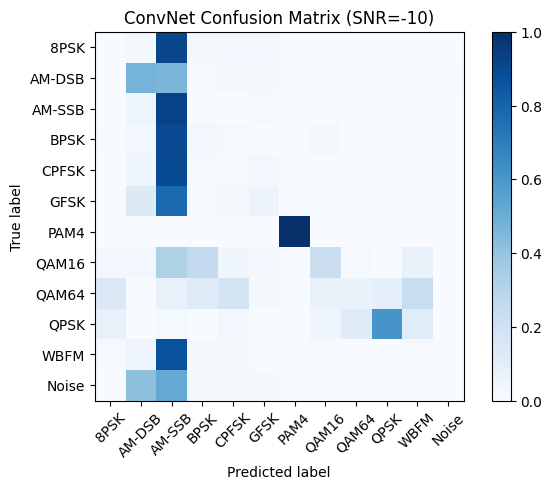

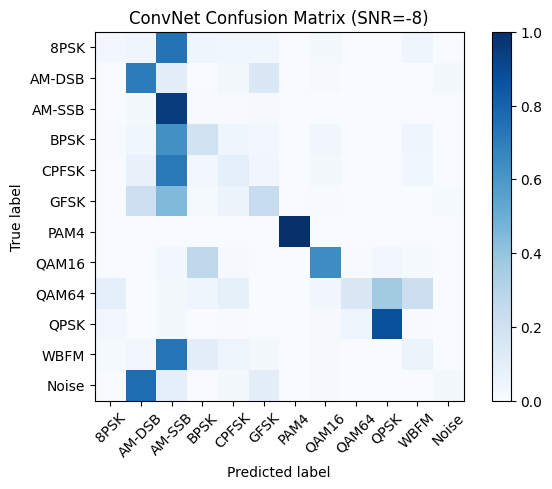

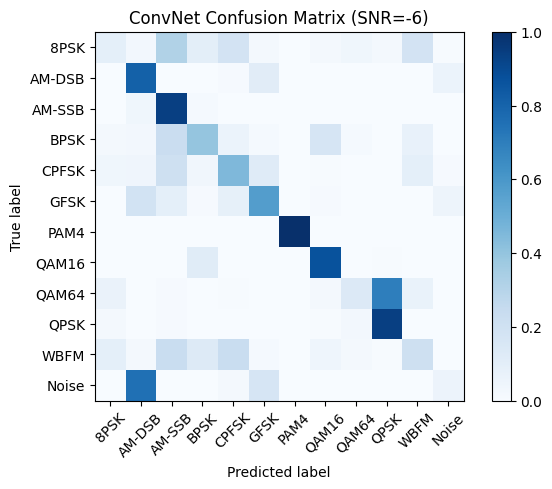

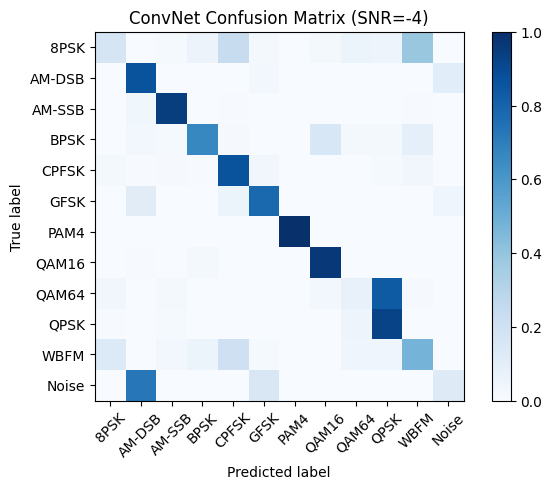

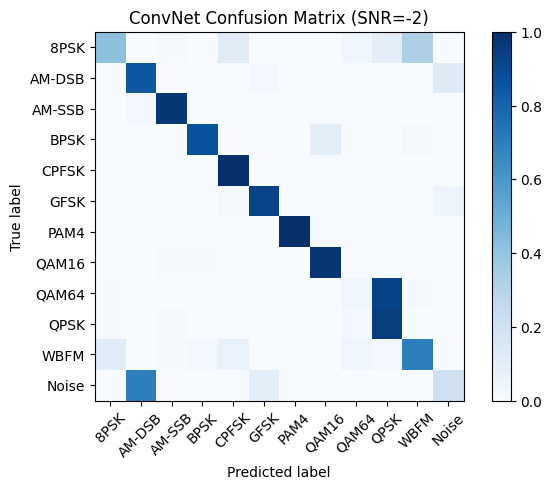

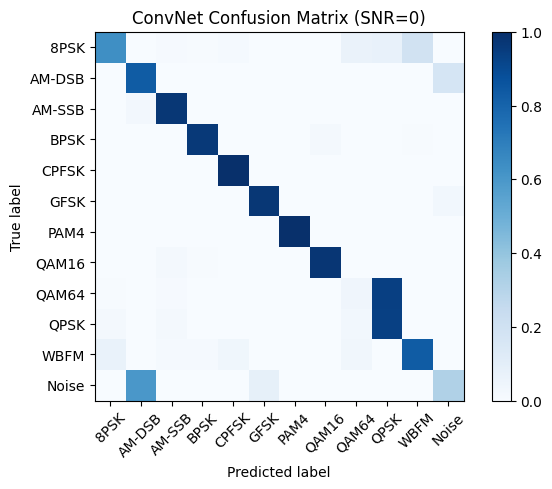

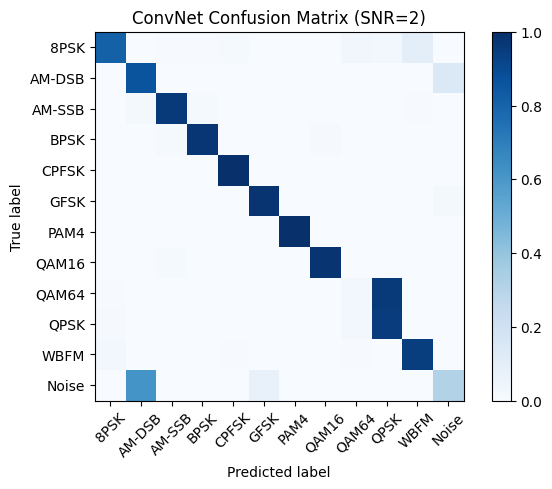

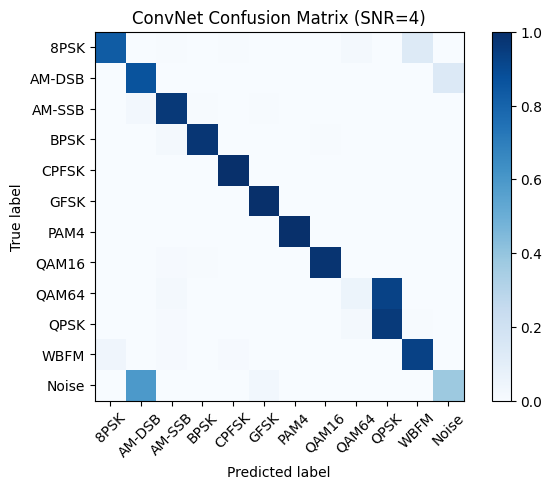

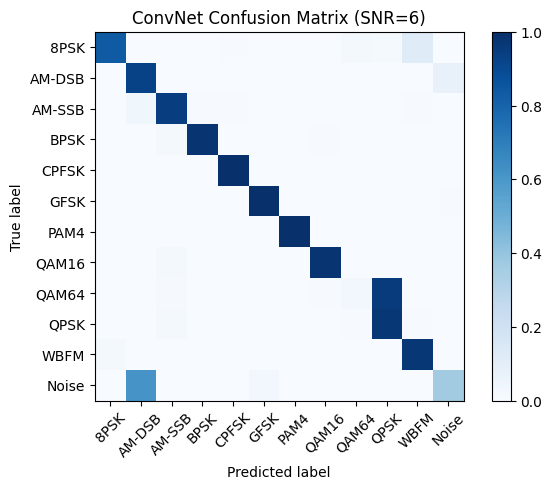

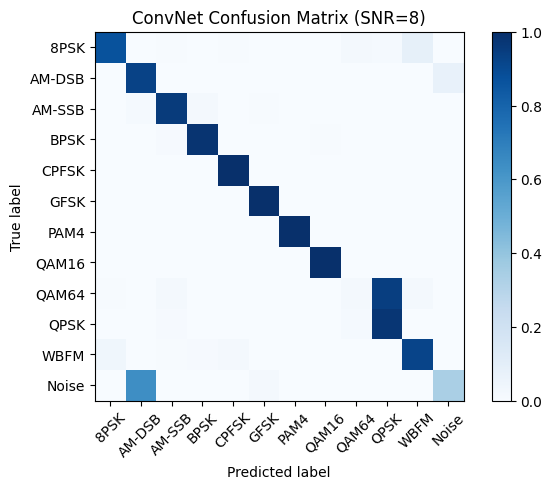

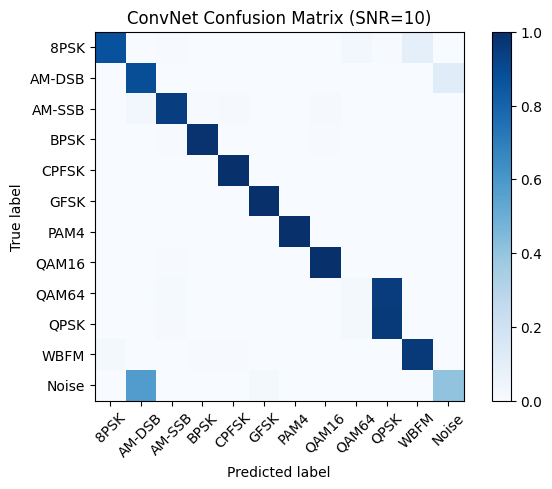

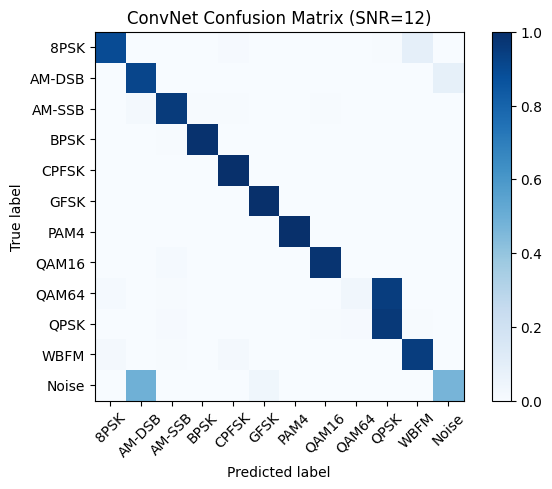

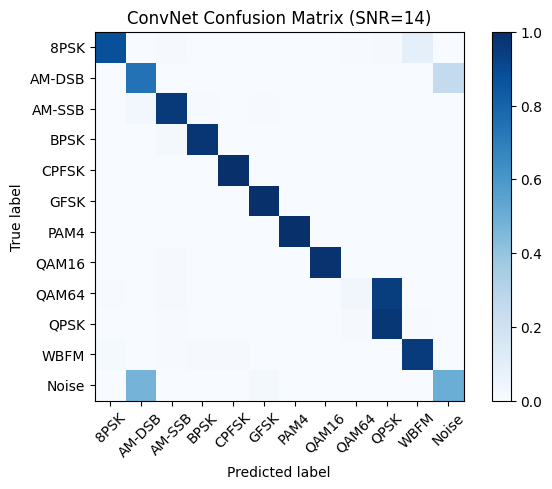

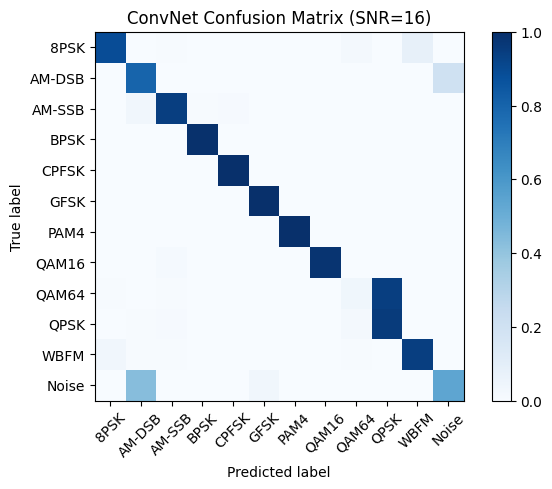

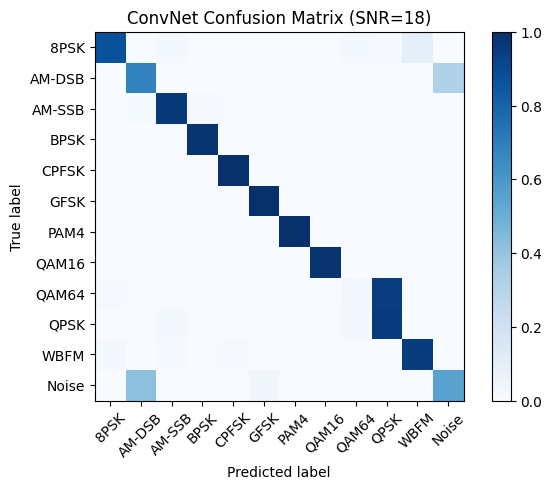

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)

    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]

    # estimate classes
    test_Y_i_hat = model1.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)


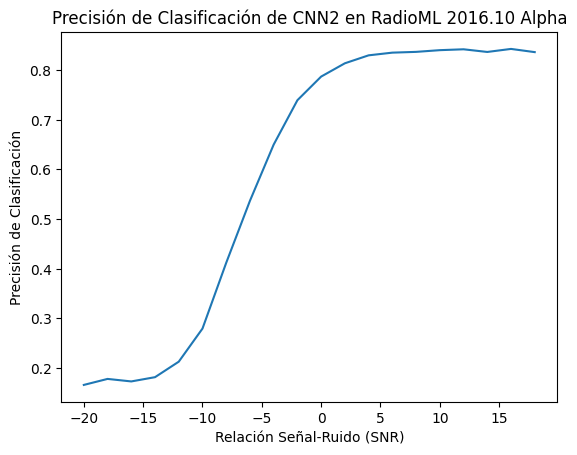

In [ ]:
# Plot accuracy curve
# Convertir el resultado de map en una lista
accuracy_values = [acc[x] for x in snrs]

# Graficar
plt.plot(snrs, accuracy_values)
plt.xlabel("Relación Señal-Ruido (SNR)")
plt.ylabel("Precisión de Clasificación")
plt.title("Precisión de Clasificación de CNN2 en RadioML 2016.10 Alpha")
plt.show()


# Análisis

Inicialmente, vamos a partir de la gráfica que contiene el error de validación y el error de entrenamiento. Se debe tener en cuenta que, el error de validación debe ser más pequeño que el error de entrenamiento, si fuese mayor es cuando el modelo se encuentra sobreentrenado. Es importante tener como referencia las épocas, ya que si se hiciera un análisis con pocas épocas o con valores pequeños alusivos a las épocas no podríamos saber con detalle cómo se comportan ambas gráficas dentro del modelo. Tal como sucede en la gráfica del **modelo 2**.

En la gráfica del **modelo 1** es posible analizar que cuando los valores de las épocas son altos el sistema termina por sobreentrenarse en comparación con el segundo modelo. Además, los valores de error son más altos en comparación al **modelo 2** lo que quiere decir que el segundo modelo es mejor.

Para las matrices de confusión en ambos modelos se puede apreciar que el modelo es acorde dado que cada una de las clases corresponden en su casilla (diagonal), la intensidad en cada una de las casillas define la presición. Tanto en el **modelo 1 y 2** se destacan la modulación AM-SSB y PAM4. También es posible evidenciar a través del barrido de valores de la relación señal a ruido que cuando esta incrementa (ruido disminuye) los modelos se estabilizan y se comportan con presición.  

Finalmente, si se comparan las gráficas finales (gráficas de precision) podemos ver como la correspondiente al **modelo 2** alcanza mejores valores (por encima de 0.8), mientras que la del **modelo 1** se ve una gráfica con más cambios bruscos con valores mayores a 0.7. Confirmando que el **modelo 2** tiene un mejor comportamiento.

# Conclusiones

* Las redes neuronales tienen una grancapacidad para aprendes patrones y representaciones complejas a partir de datos. Esto hace que sean sumamente eficaces en multiples tareas destacando el procesamiento de lenguaje natural y el reconocimiento de imágenes.









